In [3]:
import numpy as np
import pandas as pd
import math
from collections import Counter
from itertools import product
from tqdm import tqdm
import pickle
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
rating_df = pd.read_csv('../data/cleaned/cleaned_user_rating.csv')
rating_df_copy = rating_df.copy()
movies_df = pd.read_csv('../data/cleaned/cleaned_movies_details.csv', usecols=['movie_id', 'title', 'genres', 'overview', 'director', 'stars', 'img_url'])

# Only keep users with >= 5 ratings
user_rating_counts = rating_df_copy['user_id'].value_counts()
users_with_5_or_more_ratings = user_rating_counts[user_rating_counts >= 5].index
rating_df_copy = rating_df_copy[rating_df_copy['user_id'].isin(users_with_5_or_more_ratings)]
rating_df_copy = rating_df_copy.reset_index(drop=True)

# ID to number
rating_df_copy['user_id_number'] = rating_df_copy['user_id'].astype('category').cat.codes.values
rating_df_copy['movie_id_number'] = rating_df_copy['movie_id'].astype('category').cat.codes.values

all_data = rating_df_copy[['user_id_number', 'movie_id_number', 'rating']].values

In [5]:
movies_df['genres'] = movies_df['genres'].str.replace(',',' ')
movies_df['genres'] = movies_df['genres'].str.replace('Sci-Fi','SciFi')
movies_df['genres'] = movies_df['genres'].str.replace('Film-Noir','FilmNoir')
movies_df['genres'] = movies_df['genres'].str.replace('Reality-TV','RealityTV')
movies_df['genres'] = movies_df['genres'].str.replace('Talk-Show','TalkShow')
# Update content creation for semantic embeddings
movies_df['content'] = movies_df.apply(
    lambda x: f"{x['title']} is a {x['genres']} movie directed by {x['director']} starring {x['stars']}. Overview: {x['overview']}",
    axis=1
)

# Generate TF-IDF embeddings
vectorizer = TfidfVectorizer(max_features=10000)  # Limit features to speed up
tfidf_embeddings = vectorizer.fit_transform(movies_df['content']).toarray()

In [6]:
display(rating_df_copy)
# Build the mappings
number_to_user_id = dict(enumerate(rating_df_copy['user_id'].astype('category').cat.categories))
user_id_to_number = {v: k for k, v in number_to_user_id.items()}
number_to_movie_id = dict(enumerate(rating_df_copy['movie_id'].astype('category').cat.categories))
movie_id_to_number = {v: k for k, v in number_to_movie_id.items()}
# Example: Get user_id_number for a specific user_id
print(user_id_to_number['ur127508339'])
print(movie_id_to_number['tt7737800'])
# Example: Get user_id for a specific user_id_number
print(number_to_user_id[2255])

,user_id,movie_id,rating,user_id_number,movie_id_number
0,ur127508339,tt7737800,8,2255,17394
1,ur150453978,tt7737800,1,2729,17394
2,ur18519281,tt7737800,3,3344,17394
3,ur0806494,tt7737800,7,1270,17394
4,ur36401655,tt7737800,9,5381,17394
...,...,...,...,...,...
174096,ur16161013,tt0062292,8,2952,1504
174097,ur1399158,tt0062292,7,2541,1504
174098,ur15148330,tt0062292,8,2755,1504
174099,ur1793363,tt0158610,9,3253,6653


2255
17394
ur127508339


In [7]:
def get_movieURL(movie_id):
    return movies_df[movies_df.movie_id == movie_id].img_url.values[0]

print(get_movieURL('tt7737800'))

https://m.media-amazon.com/images/M/MV5BYzliNzRjNDMtYTFmOS00NDQxLWJlOWMtZTViNjcyMzc0NzQwXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg


In [8]:
def evaluate_recommendation(cf_model, test_data, n_top=5):
    hit_ratios, ndcg_scores = [], []
    
    for u in np.unique(test_data[:, 0]):
        # Get movies with ratings 8-10 in test data
        user_test_ratings = test_data[test_data[:, 0] == u]
        high_rated_test_movies = user_test_ratings[user_test_ratings[:, 2] >= 8, 1]
        
        if len(high_rated_test_movies) != 0:
            # Get all unrated movies
            train_movies = cf_model.train_data[cf_model.train_data[:, 0] == u, 1]
            all_movies = np.arange(cf_model.n_movies)
            unrated_movies = all_movies[~np.isin(all_movies, np.concatenate([train_movies, user_test_ratings[:, 1]]))]
            
            # Combine the high-rated movie with 99 other unrated movies
            sampled_unrated_movies = np.random.choice(unrated_movies, 99, replace=False)
            
            hit_ratio = 0
            dcg = 0
            # For each high-rated test movie
            for high_rated_movie in high_rated_test_movies:
                
                candidate_movies = np.concatenate([[high_rated_movie], sampled_unrated_movies])
                movie_scores = {i: cf_model.pred(u, i) for i in candidate_movies}
                
                # Sort movies by predicted score
                sorted_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:n_top]
                
                # Calculate the benchmark
                if high_rated_movie in sorted_movies:
                    hit_ratio += 1 
                    rank = sorted_movies.index(high_rated_movie) + 1
                    dcg += 1 / math.log2(rank + 1)  # Discount for rank
            hit_ratios.append(hit_ratio / len(high_rated_test_movies))
            ndcg_scores.append(dcg / len(high_rated_test_movies))
            
    return np.mean(hit_ratios), np.mean(ndcg_scores)

In [9]:
def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [10]:
data = np.load('../checkpoints/data.npz')
train_data = data['train']
val_data = data['val']
test_data = data['test']

## ISMF

In [9]:
class ISMF(object):
    global user_id_to_number, number_to_user_id, movie_id_to_number, number_to_movie_id
    def __init__(self, train_data, test_data, n_factors=10, learning_rate=0.01, n_epochs=10):
        self.train_data = train_data
        self.test_data = test_data
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.n_users = int(np.max(self.train_data[:, 0])) + 1 # 1 because index from 0
        self.n_movies = int(np.max(self.train_data[:, 1])) + 1 
        # P, Q's size may be big at first to add new user/film
        self.P = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_users + 100, self.n_factors))
        self.Q = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_movies + 100, self.n_factors))
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def fit(self):
        best_loss = float('inf')
        no_improve_epochs = 0
        
        for epoch in range(self.n_epochs):
            np.random.shuffle(self.train_data)
            # Use tqdm to create a progress bar for the inner loop
            for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
                u, i = int(u), int(i)
                pred = self.pred(u, i)
                error = r - pred
                # Update P and Q
                old_P = self.P[u, :]
                self.P[u, :] += self.learning_rate * error * self.Q[i, :]
                self.Q[i, :] += self.learning_rate * error * old_P
            
            train_loss = self.loss(self.train_data)
            test_loss = self.loss(self.test_data)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            
            # Early stopping logic
            if test_loss < best_loss + 1e-6:
                best_loss = test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= 5:
                    print("Early stopping: No improvement for 5 consecutive epochs.")
                    break

    def incremental_update(self, new_ratings):
        # Convert new_ratings from IDs to numerical indices
        processed_ratings = []
        for user_id, movie_id, rating in new_ratings:
            # Check and update user_id_to_number
            if user_id not in user_id_to_number:
                user_id_to_number[user_id] = self.n_users
                number_to_user_id[self.n_users] = user_id
                self.n_users += 1

            # Check and update movie_id_to_number
            if movie_id not in movie_id_to_number:
                movie_id_to_number[movie_id] = self.n_movies
                number_to_movie_id[self.n_movies] = movie_id
                self.n_movies += 1

            # Convert IDs to numbers and append to processed_ratings
            u = user_id_to_number[user_id]
            i = movie_id_to_number[movie_id]
            processed_ratings.append([u, i, rating])

        # Convert processed_ratings to a NumPy array
        processed_ratings = np.array(processed_ratings)
        # Update the train_data matrix with the new ratings
        self.train_data = np.vstack((self.train_data, processed_ratings))
        # Incremental learning using new ratings
        for u, i, r in processed_ratings:
            u, i, r = int(u), int(i), int(r)
            pred = self.pred(u, i)
            error = r - pred
            # Update P and Q
            old_P = self.P[u, :]
            self.P[u, :] += self.learning_rate * error * self.Q[i, :]
            self.Q[i, :] += self.learning_rate * error * old_P

    def pred(self, u, i):
        return self.P[u, :].dot(self.Q[i, :].T)
            
    def print_recommendation(self, user_id, number=10):
        recommended_items = self.recommend(user_id_to_number[user_id])
        recommended_items = recommended_items[:number]
        
        print(f'Recommended movie(s) for user {user_id} : {recommended_items}')
            
        cols = 5 if number > 5 else number
        rows = math.ceil(number/cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        urls = []

        for i in recommended_items:
            movie_id = number_to_movie_id[i]
            urls.append(get_movieURL(movie_id))
            
        for i, ax in enumerate(axes.flat):
            if i < number:
                ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
                fig.tight_layout()
                ax.axis('off')
            else:
                ax.axis('off')
            
    def recommend(self, u):        
        """
        Determine all unrated items should be recommended for user u
        """
        ids = np.where(self.train_data[:, 0] == u)[0]
        items_rated_by_u = self.train_data[ids, 1].tolist()
        recommended_items = {}
        for i in range(self.n_movies):
            if i not in items_rated_by_u:
                recommended_items[i] = self.pred(u, i)

        return sorted(recommended_items, key=recommended_items.get, reverse=True)
    
    def loss(self, data):
        L = 0
        for u, i, r in (data):
            u, i = int(u), int(i)
            pred = self.pred(u, i)
            L += (r - pred)**2
        L /= data.shape[0]
        return math.sqrt(L)

Epoch 1/100: 100%|██████████| 300578/300578 [00:03<00:00, 81130.15rating/s]


Train loss: 6.7004
Test loss: 6.6824


Epoch 2/100: 100%|██████████| 300578/300578 [00:03<00:00, 94632.70rating/s]


Train loss: 6.6997
Test loss: 6.6823


Epoch 3/100: 100%|██████████| 300578/300578 [00:03<00:00, 86218.63rating/s]


Train loss: 6.6990
Test loss: 6.6822


Epoch 4/100: 100%|██████████| 300578/300578 [00:03<00:00, 88508.54rating/s]


Train loss: 6.6983
Test loss: 6.6821


Epoch 5/100: 100%|██████████| 300578/300578 [00:03<00:00, 91961.54rating/s]


Train loss: 6.6976
Test loss: 6.6820


Epoch 6/100: 100%|██████████| 300578/300578 [00:04<00:00, 70620.73rating/s]


Train loss: 6.6970
Test loss: 6.6820


Epoch 7/100: 100%|██████████| 300578/300578 [00:03<00:00, 91354.65rating/s]


Train loss: 6.6963
Test loss: 6.6819


Epoch 8/100: 100%|██████████| 300578/300578 [00:03<00:00, 92527.71rating/s]


Train loss: 6.6956
Test loss: 6.6818


Epoch 9/100: 100%|██████████| 300578/300578 [00:03<00:00, 86573.62rating/s]


Train loss: 6.6949
Test loss: 6.6817


Epoch 10/100: 100%|██████████| 300578/300578 [00:03<00:00, 93549.53rating/s]


Train loss: 6.6943
Test loss: 6.6817


Epoch 11/100: 100%|██████████| 300578/300578 [00:03<00:00, 86072.13rating/s]


Train loss: 6.6936
Test loss: 6.6816


Epoch 12/100: 100%|██████████| 300578/300578 [00:03<00:00, 91939.90rating/s]


Train loss: 6.6929
Test loss: 6.6815


Epoch 13/100: 100%|██████████| 300578/300578 [00:03<00:00, 95540.14rating/s]


Train loss: 6.6923
Test loss: 6.6815


Epoch 14/100: 100%|██████████| 300578/300578 [00:03<00:00, 92362.91rating/s]


Train loss: 6.6916
Test loss: 6.6814


Epoch 15/100: 100%|██████████| 300578/300578 [00:03<00:00, 88120.93rating/s]


Train loss: 6.6910
Test loss: 6.6814


Epoch 16/100: 100%|██████████| 300578/300578 [00:03<00:00, 95393.01rating/s] 


Train loss: 6.6903
Test loss: 6.6813


Epoch 17/100: 100%|██████████| 300578/300578 [00:03<00:00, 80962.42rating/s]


Train loss: 6.6896
Test loss: 6.6813


Epoch 18/100: 100%|██████████| 300578/300578 [00:04<00:00, 70235.78rating/s]


Train loss: 6.6890
Test loss: 6.6812


Epoch 19/100: 100%|██████████| 300578/300578 [00:03<00:00, 89167.62rating/s]


Train loss: 6.6883
Test loss: 6.6812


Epoch 20/100: 100%|██████████| 300578/300578 [00:03<00:00, 86369.15rating/s]


Train loss: 6.6877
Test loss: 6.6811


Epoch 21/100: 100%|██████████| 300578/300578 [00:03<00:00, 86916.67rating/s]


Train loss: 6.6870
Test loss: 6.6811


Epoch 22/100: 100%|██████████| 300578/300578 [00:03<00:00, 89008.23rating/s]


Train loss: 6.6864
Test loss: 6.6810


Epoch 23/100: 100%|██████████| 300578/300578 [00:03<00:00, 94071.49rating/s]


Train loss: 6.6857
Test loss: 6.6810


Epoch 24/100: 100%|██████████| 300578/300578 [00:03<00:00, 95159.10rating/s]


Train loss: 6.6851
Test loss: 6.6809


Epoch 25/100: 100%|██████████| 300578/300578 [00:03<00:00, 95180.89rating/s]


Train loss: 6.6844
Test loss: 6.6809


Epoch 26/100: 100%|██████████| 300578/300578 [00:03<00:00, 97000.32rating/s]


Train loss: 6.6838
Test loss: 6.6809


Epoch 27/100: 100%|██████████| 300578/300578 [00:03<00:00, 95136.83rating/s]


Train loss: 6.6831
Test loss: 6.6808


Epoch 28/100: 100%|██████████| 300578/300578 [00:03<00:00, 95061.61rating/s] 


Train loss: 6.6825
Test loss: 6.6808


Epoch 29/100: 100%|██████████| 300578/300578 [00:03<00:00, 92297.41rating/s]


Train loss: 6.6818
Test loss: 6.6808


Epoch 30/100: 100%|██████████| 300578/300578 [00:03<00:00, 95238.42rating/s]


Train loss: 6.6812
Test loss: 6.6807


Epoch 31/100: 100%|██████████| 300578/300578 [00:03<00:00, 90614.13rating/s]


Train loss: 6.6805
Test loss: 6.6807


Epoch 32/100: 100%|██████████| 300578/300578 [00:03<00:00, 96652.06rating/s] 


Train loss: 6.6799
Test loss: 6.6807


Epoch 33/100: 100%|██████████| 300578/300578 [00:03<00:00, 94461.44rating/s]


Train loss: 6.6792
Test loss: 6.6806


Epoch 34/100: 100%|██████████| 300578/300578 [00:03<00:00, 91402.25rating/s]


Train loss: 6.6786
Test loss: 6.6806


Epoch 35/100: 100%|██████████| 300578/300578 [00:03<00:00, 95264.16rating/s] 


Train loss: 6.6779
Test loss: 6.6806


Epoch 36/100: 100%|██████████| 300578/300578 [00:03<00:00, 93911.88rating/s] 


Train loss: 6.6773
Test loss: 6.6806


Epoch 37/100: 100%|██████████| 300578/300578 [00:03<00:00, 93670.36rating/s] 


Train loss: 6.6767
Test loss: 6.6806


Epoch 38/100: 100%|██████████| 300578/300578 [00:03<00:00, 93055.68rating/s]


Train loss: 6.6760
Test loss: 6.6805


Epoch 39/100: 100%|██████████| 300578/300578 [00:03<00:00, 96542.48rating/s] 


Train loss: 6.6754
Test loss: 6.6805


Epoch 40/100: 100%|██████████| 300578/300578 [00:03<00:00, 93880.04rating/s]


Train loss: 6.6747
Test loss: 6.6805


Epoch 41/100: 100%|██████████| 300578/300578 [00:03<00:00, 90573.93rating/s]


Train loss: 6.6741
Test loss: 6.6805


Epoch 42/100: 100%|██████████| 300578/300578 [00:03<00:00, 96309.87rating/s] 


Train loss: 6.6734
Test loss: 6.6805


Epoch 43/100: 100%|██████████| 300578/300578 [00:03<00:00, 92362.57rating/s]


Train loss: 6.6728
Test loss: 6.6805


Epoch 44/100: 100%|██████████| 300578/300578 [00:03<00:00, 87155.88rating/s]


Train loss: 6.6721
Test loss: 6.6804


Epoch 45/100: 100%|██████████| 300578/300578 [00:03<00:00, 92890.13rating/s]


Train loss: 6.6715
Test loss: 6.6804


Epoch 46/100: 100%|██████████| 300578/300578 [00:03<00:00, 92800.25rating/s]


Train loss: 6.6708
Test loss: 6.6804


Epoch 47/100: 100%|██████████| 300578/300578 [00:03<00:00, 98020.83rating/s] 


Train loss: 6.6702
Test loss: 6.6804


Epoch 48/100: 100%|██████████| 300578/300578 [00:03<00:00, 94474.16rating/s] 


Train loss: 6.6695
Test loss: 6.6804


Epoch 49/100: 100%|██████████| 300578/300578 [00:03<00:00, 94627.84rating/s] 


Train loss: 6.6689
Test loss: 6.6804


Epoch 50/100: 100%|██████████| 300578/300578 [00:03<00:00, 98907.56rating/s] 


Train loss: 6.6682
Test loss: 6.6804


Epoch 51/100: 100%|██████████| 300578/300578 [00:03<00:00, 97290.25rating/s]


Train loss: 6.6676
Test loss: 6.6804


Epoch 52/100: 100%|██████████| 300578/300578 [00:03<00:00, 99688.40rating/s] 


Train loss: 6.6669
Test loss: 6.6804


Epoch 53/100: 100%|██████████| 300578/300578 [00:03<00:00, 97586.23rating/s] 


Train loss: 6.6663
Test loss: 6.6804


Epoch 54/100: 100%|██████████| 300578/300578 [00:03<00:00, 97999.06rating/s] 


Train loss: 6.6656
Test loss: 6.6804


Epoch 55/100: 100%|██████████| 300578/300578 [00:03<00:00, 90771.91rating/s]


Train loss: 6.6649
Test loss: 6.6804


Epoch 56/100: 100%|██████████| 300578/300578 [00:03<00:00, 97599.80rating/s] 


Train loss: 6.6643
Test loss: 6.6804


Epoch 57/100: 100%|██████████| 300578/300578 [00:03<00:00, 96117.52rating/s] 


Train loss: 6.6636
Test loss: 6.6804


Epoch 58/100: 100%|██████████| 300578/300578 [00:03<00:00, 99852.69rating/s] 


Train loss: 6.6629
Test loss: 6.6804


Epoch 59/100: 100%|██████████| 300578/300578 [00:03<00:00, 99325.45rating/s] 


Train loss: 6.6623
Test loss: 6.6804


Epoch 60/100: 100%|██████████| 300578/300578 [00:03<00:00, 93059.25rating/s]


Train loss: 6.6616
Test loss: 6.6804


Epoch 61/100: 100%|██████████| 300578/300578 [00:03<00:00, 94630.40rating/s]


Train loss: 6.6609
Test loss: 6.6804
Early stopping: No improvement for 5 consecutive epochs.
Recommended movie(s) for user ur127508339 : [9022, 7994, 10700, 5141, 12963, 12191, 8675, 9324, 17595, 11175]


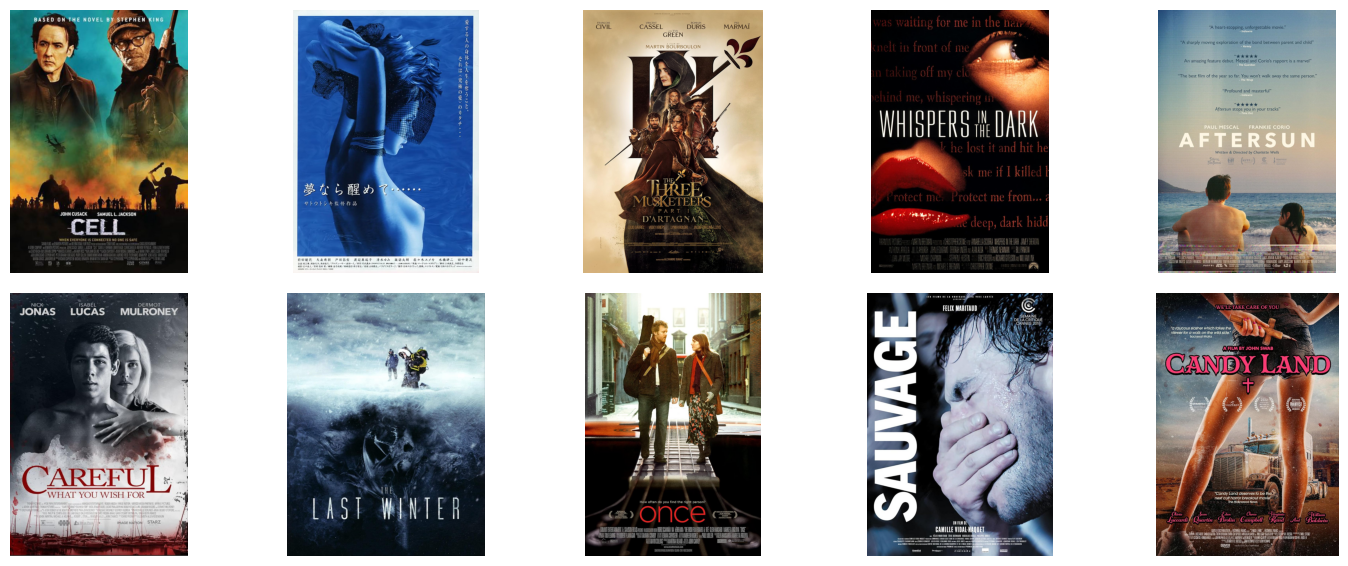

In [11]:
cf_model = ISMF(train_data, test_data, n_factors=2, learning_rate=1e-4, n_epochs=100)
cf_model.fit()
cf_model.print_recommendation('ur127508339')
# Add new ratings incrementally
new_ratings = np.array([['ur127508339', 'tt0062292', 3], ['ur6969', 'tt6969', 7]])  # Example new ratings
cf_model.incremental_update(new_ratings)

In [12]:
# # Hyperparameter grid
# n_factors_list = [200, 300, 400, 500] # [5, 10, 20, 50]
# learning_rates = [2e-3, 4e-3, 6e-3, 8e-3] # [1e-3, 1e-2, 5e-2, 1e-1]

# # Open the CSV file and write the header once
# csv_file_path = '../results/ismf_results.csv'
# with open(csv_file_path, 'w', newline='') as csvfile:
#     fieldnames = ['n_factors', 'learning_rate', 'HR', 'NDCG']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()

# # Evaluate across all hyperparameter combinations
# for n_factors, learning_rate in product(n_factors_list, learning_rates):
#     # Initialize the model
#     cf_model = ISMF(train_data, val_data, n_factors=n_factors, learning_rate=learning_rate, n_epochs=100)
#     print(f"ismf, n_factors: {n_factors}, learning_rate: {learning_rate}")
    
#     # Train the model
#     cf_model.fit()
    
#     # Evaluate the model
#     hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top=5)
#     print(f"Results - n_factors: {n_factors}, learning_rate: {learning_rate}, HR: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")
    
#     # Save the model
#     model_filename = f"../models/ismf/ismf_nf{n_factors}_lr{learning_rate}.pkl"
#     cf_model.save(model_filename)
    
#     # Append the result to the CSV file
#     with open(csv_file_path, 'a', newline='') as csvfile:
#         writer = csv.DictWriter(csvfile, fieldnames=['n_factors', 'learning_rate', 'HR', 'NDCG'])
#         writer.writerow({
#             'n_factors': n_factors, 
#             'learning_rate': learning_rate, 
#             'HR': f"{hit_ratio:.4f}", 
#             'NDCG': f"{ndcg:.4f}"
#         })

## RISMF

In [13]:
class RISMF(object):
    global user_id_to_number, number_to_user_id, movie_id_to_number, number_to_movie_id
    def __init__(self, train_data, test_data, n_factors=10, learning_rate=0.01, lambda_reg=0.1, n_epochs=10):
        self.train_data = train_data
        self.test_data = test_data
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.n_epochs = n_epochs
        self.n_users = int(np.max(self.train_data[:, 0])) + 1 # 1 because index from 0
        self.n_movies = int(np.max(self.train_data[:, 1])) + 1
         
        # P, Q's size may be big at first to add new user/film
        self.P = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_users + 100, self.n_factors))
        self.Q = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_movies + 100, self.n_factors))
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def fit(self):
        best_loss = float('inf')
        no_improve_epochs = 0
        
        for epoch in range(self.n_epochs):
            np.random.shuffle(self.train_data)
            # Use tqdm to create a progress bar for the inner loop
            for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
                u, i = int(u), int(i)
                pred = self.pred(u, i)
                error = r - pred
                # Update P and Q
                self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
                self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

            train_loss = self.loss(self.train_data)
            test_loss = self.loss(self.test_data)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            
            # Early stopping logic
            if test_loss < best_loss + 1e-6:
                best_loss = test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= 5:
                    print("Early stopping: No improvement for 5 consecutive epochs.")
                    break
                
    def fit_retraining(self):
        best_loss = float('inf')
        no_improve_epochs = 0
        
        for epoch in range(self.n_epochs):
            np.random.shuffle(self.train_data)
            # Use tqdm to create a progress bar for the inner loop
            for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
                u, i = int(u), int(i)
                pred = self.pred(u, i)
                error = r - pred
                # Update P and Q
                self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
                self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

            train_loss = self.loss(self.train_data)
            test_loss = self.loss(self.test_data)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            
            # Early stopping logic
            if test_loss < best_loss + 1e-6:
                best_loss = test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= 5:
                    print("Early stopping: No improvement for 5 consecutive epochs.")
                    break
        
        # Retrain, same logic but Q is fixed
        best_loss = float('inf')
        no_improve_epochs = 0
        
        for epoch in range(self.n_epochs):
            np.random.shuffle(self.train_data)
            # Use tqdm to create a progress bar for the inner loop
            for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
                u, i = int(u), int(i)
                pred = self.pred(u, i)
                error = r - pred
                # Update P and Q
                self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])

            train_loss = self.loss(self.train_data)
            test_loss = self.loss(self.test_data)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            
            # Early stopping logic
            if test_loss < best_loss + 1e-6:
                best_loss = test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= 5:
                    print("Early stopping: No improvement for 5 consecutive epochs.")
                    break
                
    def incremental_update(self, new_ratings):
        # Convert new_ratings from IDs to numerical indices
        processed_ratings = []
        for user_id, movie_id, rating in new_ratings:
            # Check and update user_id_to_number
            if user_id not in user_id_to_number:
                user_id_to_number[user_id] = self.n_users
                number_to_user_id[self.n_users] = user_id
                self.n_users += 1

            # Check and update movie_id_to_number
            if movie_id not in movie_id_to_number:
                movie_id_to_number[movie_id] = self.n_movies
                number_to_movie_id[self.n_movies] = movie_id
                self.n_movies += 1

            # Convert IDs to numbers and append to processed_ratings
            u = user_id_to_number[user_id]
            i = movie_id_to_number[movie_id]
            processed_ratings.append([u, i, rating])

        # Convert processed_ratings to a NumPy array
        processed_ratings = np.array(processed_ratings)
        # Update the train_data matrix with the new ratings
        self.train_data = np.vstack((self.train_data, processed_ratings))
        # Incremental learning using new ratings
        for u, i, r in processed_ratings:
            u, i, r = int(u), int(i), int(r)
            pred = self.pred(u, i)
            error = r - pred
            # Update P and Q
            self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
            self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

    def pred(self, u, i):
        return self.P[u, :].dot(self.Q[i, :].T)
    
    def pred_neighborhood_based(self, u, i):
        self.gamma = 0.05
        # Base prediction
        base_prediction = self.P[u, :].dot(self.Q[i, :].T)

        # Items rated by user u excluding i
        ids = np.where(self.train_data[:, 0] == u)[0]
        items_rated_by_u = self.train_data[ids, 1].tolist()
        items_rated_by_u = [j for j in items_rated_by_u if j != i]

        if not items_rated_by_u:
            return base_prediction

        # Similarity-adjusted prediction with TF-IDF embeddings
        similarity_adjustment = 0
        similarity_sum = 0
        for j in items_rated_by_u:
            similarity = cosine_similarity([tfidf_embeddings[i]], [tfidf_embeddings[j]])[0][0]
            similarity_sum += similarity
            rating_diff = self.P[u, :].dot(self.Q[j, :].T) - self.train_data[ids[np.where(self.train_data[ids, 1] == j)[0][0]], 2]
            similarity_adjustment += similarity * rating_diff

        if similarity_sum > 0:
            similarity_adjustment /= similarity_sum

        return base_prediction + self.gamma * similarity_adjustment
            
    def print_recommendation(self, user_id, number=10):
        recommended_items = self.recommend(user_id_to_number[user_id])
        recommended_items = recommended_items[:number]
        
        print(f'Recommended movie(s) for user {user_id} : {recommended_items}')
            
        cols = 5 if number > 5 else number
        rows = math.ceil(number/cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        urls = []

        for i in recommended_items:
            movie_id = number_to_movie_id[i]
            urls.append(get_movieURL(movie_id))
            
        for i, ax in enumerate(axes.flat):
            if i < number:
                ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
                fig.tight_layout()
                ax.axis('off')
            else:
                ax.axis('off')
            
    def recommend(self, u):        
        """
        Determine all unrated items should be recommended for user u
        """
        ids = np.where(self.train_data[:, 0] == u)[0]
        items_rated_by_u = self.train_data[ids, 1].tolist()
        recommended_items = {}
        for i in range(self.n_movies):
            if i not in items_rated_by_u:
                recommended_items[i] = self.pred(u, i)

        return sorted(recommended_items, key=recommended_items.get, reverse=True)
    
    def loss(self, data):
        L = 0
        for u, i, r in (data):
            u, i = int(u), int(i)
            pred = self.pred(u, i)
            L += (r - pred)**2
        L /= data.shape[0]
        return math.sqrt(L)

In [14]:
def evaluate_recommendation_neighborhood_based(cf_model, test_data, n_top=5):
    hit_ratios, ndcg_scores = [], []
    
    unique_users = np.unique(test_data[:, 0])
    # unique_users = unique_users[:len(unique_users) // 2]
    unique_users = unique_users[len(unique_users) // 2:]
    for u in tqdm(unique_users, desc="Evaluating Users"):
        # Get movies with ratings 8-10 in test data
        user_test_ratings = test_data[test_data[:, 0] == u]
        high_rated_test_movies = user_test_ratings[user_test_ratings[:, 2] >= 8, 1]
        
        if len(high_rated_test_movies) != 0:
            # Get all unrated movies
            train_movies = cf_model.train_data[cf_model.train_data[:, 0] == u, 1]
            all_movies = np.arange(cf_model.n_movies)
            unrated_movies = all_movies[~np.isin(all_movies, np.concatenate([train_movies, user_test_ratings[:, 1]]))]
            
            # Combine the high-rated movie with 99 other unrated movies
            sampled_unrated_movies = np.random.choice(unrated_movies, 99, replace=False)
            
            hit_ratio = 0
            dcg = 0
            # For each high-rated test movie
            for high_rated_movie in high_rated_test_movies:
                
                candidate_movies = np.concatenate([[high_rated_movie], sampled_unrated_movies])
                movie_scores = {i: cf_model.pred_neighborhood_based(u, i) for i in candidate_movies}
                
                # Sort movies by predicted score
                sorted_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:n_top]
                
                # Calculate the benchmark
                if high_rated_movie in sorted_movies:
                    hit_ratio += 1 
                    rank = sorted_movies.index(high_rated_movie) + 1
                    dcg += 1 / math.log2(rank + 1)  # Discount for rank
            hit_ratios.append(hit_ratio / len(high_rated_test_movies))
            ndcg_scores.append(dcg / len(high_rated_test_movies))
            
    return np.mean(hit_ratios), np.mean(ndcg_scores)

In [16]:
cf_model = load_model('../checkpoints/rismf/rismf_nf300_lr0.006.pkl')
hit_ratio, ndcg = evaluate_recommendation_neighborhood_based(cf_model, test_data, n_top=5)
print(hit_ratio)
print(ndcg)

Evaluating Users: 100%|██████████| 6084/6084 [19:03:49<00:00, 13.18s/it]
0.23948185672277647
0.1784571758056751


In [19]:
# Hyperparameter grid
n_factors_list = [200, 300, 400, 500] # [200, 300, 400, 500]
learning_rates = [2e-3, 4e-3, 6e-3, 8e-3] # [2e-3, 4e-3, 6e-3, 8e-3]

# Open the CSV file and write the header once
csv_file_path = 'results/rismf_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['n_factors', 'learning_rate', 'HR', 'NDCG']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

# Evaluate across all hyperparameter combinations
for n_factors, learning_rate in product(n_factors_list, learning_rates):
    # Initialize the model
    cf_model = RISMF(train_data, val_data, n_factors=n_factors, learning_rate=learning_rate, lambda_reg=0.1, n_epochs=100)
    print(f"rismf, n_factors: {n_factors}, learning_rate: {learning_rate}")
    
    # Train the model
    cf_model.fit()
    
    # Evaluate the model
    hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top=5)
    print(f"Results - n_factors: {n_factors}, learning_rate: {learning_rate}, HR: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")
    
    # Save the model
    model_filename = f"../checkpoints/rismf/rismf_nf{n_factors}_lr{learning_rate}.pkl"
    cf_model.save(model_filename)
    
    # Append the result to the CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['n_factors', 'learning_rate', 'HR', 'NDCG'])
        writer.writerow({
            'n_factors': n_factors, 
            'learning_rate': learning_rate, 
            'HR': f"{hit_ratio:.4f}", 
            'NDCG': f"{ndcg:.4f}"
        })

rismf, n_factors: 200, learning_rate: 0.002
Epoch 1/100: 100%|██████████| 300578/300578 [00:07<00:00, 38917.04rating/s]
Train loss: 6.0944
Test loss: 8.1316
Epoch 2/100: 100%|██████████| 300578/300578 [00:07<00:00, 40495.21rating/s]
Train loss: 6.0943
Test loss: 8.1316
Epoch 3/100: 100%|██████████| 300578/300578 [00:07<00:00, 42627.16rating/s]
Train loss: 6.0942
Test loss: 8.1315
Epoch 4/100: 100%|██████████| 300578/300578 [00:07<00:00, 42491.09rating/s]
Train loss: 6.0940
Test loss: 8.1315
Epoch 5/100: 100%|██████████| 300578/300578 [00:07<00:00, 41235.41rating/s]
Train loss: 6.0939
Test loss: 8.1315
Epoch 6/100: 100%|██████████| 300578/300578 [00:07<00:00, 40623.94rating/s]
Train loss: 6.0937
Test loss: 8.1315
Epoch 7/100: 100%|██████████| 300578/300578 [00:07<00:00, 40713.61rating/s]
Train loss: 6.0936
Test loss: 8.1315
Epoch 8/100: 100%|██████████| 300578/300578 [00:07<00:00, 41784.73rating/s]
Train loss: 6.0933
Test loss: 8.1315
Epoch 9/100: 100%|██████████| 300578/300578 [00:07<0

## Retraining RISMF

In [22]:
# Hyperparameter grid
n_factors_list = [200, 300, 400, 500] # [200, 300, 400, 500]
learning_rates = [2e-3, 4e-3, 6e-3, 8e-3] # [2e-3, 4e-3, 6e-3, 8e-3]

# Open the CSV file and write the header once
csv_file_path = 'results/rismf_retraining_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['n_factors', 'learning_rate', 'HR', 'NDCG']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

# Evaluate across all hyperparameter combinations
for n_factors, learning_rate in product(n_factors_list, learning_rates):
    # Initialize the model
    cf_model = RISMF(train_data, val_data, n_factors=n_factors, learning_rate=learning_rate, lambda_reg=0.1, n_epochs=100)
    print(f"rismf_retraining, n_factors: {n_factors}, learning_rate: {learning_rate}")
    
    # Train the model
    cf_model.fit_retraining()
    
    # Evaluate the model
    hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top=5)
    print(f"Results - n_factors: {n_factors}, learning_rate: {learning_rate}, HR: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")
    
    # Save the model
    model_filename = f"../checkpoints/rismf_retraining/rismf_retraining_nf{n_factors}_lr{learning_rate}.pkl"
    cf_model.save(model_filename)
    
    # Append the result to the CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['n_factors', 'learning_rate', 'HR', 'NDCG'])
        writer.writerow({
            'n_factors': n_factors, 
            'learning_rate': learning_rate, 
            'HR': f"{hit_ratio:.4f}", 
            'NDCG': f"{ndcg:.4f}"
        })

rismf, n_factors: 200, learning_rate: 0.002
Epoch 1/100: 100%|██████████| 300578/300578 [00:05<00:00, 52090.38rating/s]
Train loss: 6.0944
Test loss: 8.1315
Epoch 2/100: 100%|██████████| 300578/300578 [00:06<00:00, 49407.16rating/s]
Train loss: 6.0943
Test loss: 8.1315
Epoch 3/100: 100%|██████████| 300578/300578 [00:05<00:00, 51238.35rating/s]
Train loss: 6.0942
Test loss: 8.1315
Epoch 4/100: 100%|██████████| 300578/300578 [00:05<00:00, 50366.76rating/s]
Train loss: 6.0940
Test loss: 8.1315
Epoch 5/100: 100%|██████████| 300578/300578 [00:05<00:00, 52995.68rating/s]
Train loss: 6.0939
Test loss: 8.1315
Epoch 6/100: 100%|██████████| 300578/300578 [00:05<00:00, 51820.83rating/s]
Train loss: 6.0937
Test loss: 8.1315
Epoch 7/100: 100%|██████████| 300578/300578 [00:05<00:00, 51692.63rating/s]
Train loss: 6.0936
Test loss: 8.1315
Epoch 8/100: 100%|██████████| 300578/300578 [00:05<00:00, 52795.97rating/s]
Train loss: 6.0933
Test loss: 8.1314
Epoch 9/100: 100%|██████████| 300578/300578 [00:05<0

## Normalized RISMF (Normalize rating for each user)

In [10]:
class RISMFNormalized(RISMF):
    def __init__(self, train_data, test_data, n_factors=10, learning_rate=0.01, lambda_reg=0.1, n_epochs=10):
        super().__init__(train_data, test_data, n_factors, learning_rate, lambda_reg, n_epochs)
        
        # Normalize ratings
        self.mean_ratings = {}
        self.std_ratings = {}
        
        self.train_data[:, 2] = self._normalize_ratings(self.train_data)
        self.test_data[:, 2] = self._normalize_ratings(self.test_data)
        
    def _normalize_ratings(self, data):
        """
        Normalize ratings by subtracting the mean and dividing by std deviation for each user.
        """
        normalized_ratings = np.zeros_like(data[:, 2])
        for user_id in np.unique(data[:, 0]):
            user_mask = data[:, 0] == user_id
            user_ratings = data[user_mask, 2]
            mean = np.mean(user_ratings)
            std = np.std(user_ratings) if np.std(user_ratings) > 0 else 1.0
            self.mean_ratings[user_id] = mean
            self.std_ratings[user_id] = std
            normalized_ratings[user_mask] = (user_ratings - mean) / std
        return normalized_ratings

    def _denormalize_rating(self, u, pred):
        """
        Convert normalized prediction back to the original scale using user's mean and std.
        """
        mean = self.mean_ratings.get(u, 0)
        std = self.std_ratings.get(u, 1)
        return pred * std + mean

    def pred(self, u, i):
        """
        Predict normalized ratings and denormalize them to the original scale.
        """
        normalized_pred = super().pred(u, i)
        return self._denormalize_rating(u, normalized_pred)

In [ ]:
# Hyperparameter grid
n_factors_list = [200, 300, 400, 500] # [200, 300, 400, 500]
learning_rates = [2e-3, 4e-3, 6e-3, 8e-3] # [2e-3, 4e-3, 6e-3, 8e-3]

# Open the CSV file and write the header once
csv_file_path = 'results/rismf_normalized_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['n_factors', 'learning_rate', 'HR', 'NDCG']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

# Evaluate across all hyperparameter combinations
for n_factors, learning_rate in product(n_factors_list, learning_rates):
    # Initialize the model
    cf_model = RISMFNormalized(train_data, val_data, n_factors=n_factors, learning_rate=learning_rate, lambda_reg=0.1, n_epochs=100)
    print(f"rismf_normalized, n_factors: {n_factors}, learning_rate: {learning_rate}")
    
    # Train the model
    cf_model.fit()
    
    # Evaluate the model
    hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top=5)
    print(f"Results - n_factors: {n_factors}, learning_rate: {learning_rate}, HR: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")
    
    # Save the model
    model_filename = f"../checkpoints/rismf_normalized/rismf_normalized_nf{n_factors}_lr{learning_rate}.pkl"
    cf_model.save(model_filename)
    
    # Append the result to the CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['n_factors', 'learning_rate', 'HR', 'NDCG'])
        writer.writerow({
            'n_factors': n_factors, 
            'learning_rate': learning_rate, 
            'HR': f"{hit_ratio:.4f}", 
            'NDCG': f"{ndcg:.4f}"
        })

rismf_normalized, n_factors: 5, learning_rate: 0.001


Epoch 1/100: 100%|██████████| 300578/300578 [00:05<00:00, 55074.27rating/s]


Train loss: 6.5666
Test loss: 6.3634


Epoch 2/100: 100%|██████████| 300578/300578 [00:05<00:00, 54643.67rating/s]


Train loss: 6.5628
Test loss: 6.3632


Epoch 3/100: 100%|██████████| 300578/300578 [00:05<00:00, 54833.40rating/s]


Train loss: 6.5591
Test loss: 6.3631


Epoch 4/100: 100%|██████████| 300578/300578 [00:05<00:00, 54956.02rating/s]


Train loss: 6.5554
Test loss: 6.3630


Epoch 5/100: 100%|██████████| 300578/300578 [00:05<00:00, 55212.05rating/s]


Train loss: 6.5515
Test loss: 6.3628


Epoch 6/100: 100%|██████████| 300578/300578 [00:05<00:00, 55025.45rating/s]


Train loss: 6.5474
Test loss: 6.3627


Epoch 7/100: 100%|██████████| 300578/300578 [00:05<00:00, 55299.91rating/s]


Train loss: 6.5430
Test loss: 6.3625


Epoch 8/100: 100%|██████████| 300578/300578 [00:05<00:00, 53911.05rating/s]


Train loss: 6.5381
Test loss: 6.3622


Epoch 9/100: 100%|██████████| 300578/300578 [00:05<00:00, 54837.43rating/s]


Train loss: 6.5324
Test loss: 6.3617


Epoch 10/100: 100%|██████████| 300578/300578 [00:05<00:00, 55666.15rating/s]


Train loss: 6.5257
Test loss: 6.3608


Epoch 11/100: 100%|██████████| 300578/300578 [00:05<00:00, 50675.18rating/s]


Train loss: 6.5174
Test loss: 6.3594


Epoch 12/100: 100%|██████████| 300578/300578 [00:06<00:00, 46722.83rating/s]


Train loss: 6.5069
Test loss: 6.3572


Epoch 13/100:  15%|█▍        | 45015/300578 [00:01<00:05, 46225.66rating/s]

# BRISMF

In [24]:
class BRISMF(object):
    global user_id_to_number, number_to_user_id, movie_id_to_number, number_to_movie_id
    def __init__(self, train_data, test_data, n_factors=10, learning_rate=0.01, lambda_reg=0.1, n_epochs=10):
        self.train_data = train_data
        self.test_data = test_data
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.n_epochs = n_epochs
        self.n_users = int(np.max(self.train_data[:, 0])) + 1 # 1 because index from 0
        self.n_movies = int(np.max(self.train_data[:, 1])) + 1
         
        # P, Q's size may be big at first to add new user/film
        self.P = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_users + 100, self.n_factors))
        self.Q = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_movies + 100, self.n_factors))
        
        # Fix P[1, :] and Q[2, :] to 1
        self.P[1, :] = 1
        self.Q[2, :] = 1
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def fit(self):
        best_loss = float('inf')
        no_improve_epochs = 0
        
        for epoch in range(self.n_epochs):
            np.random.shuffle(self.train_data)
            # Use tqdm to create a progress bar for the inner loop
            for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
                u, i = int(u), int(i)
                pred = self.pred(u, i)
                error = r - pred
                
                # Skip updates for fixed rows
                if u != 1:
                    self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
                if i != 2:
                    self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])
            
            train_loss = self.loss(self.train_data)
            test_loss = self.loss(self.test_data)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            
            # Early stopping logic
            if test_loss < best_loss + 1e-6:
                best_loss = test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= 5:
                    print("Early stopping: No improvement for 5 consecutive epochs.")
                    break
                
    def incremental_update(self, new_ratings):
        # Convert new_ratings from IDs to numerical indices
        processed_ratings = []
        for user_id, movie_id, rating in new_ratings:
            # Check and update user_id_to_number
            if user_id not in user_id_to_number:
                user_id_to_number[user_id] = self.n_users
                number_to_user_id[self.n_users] = user_id
                self.n_users += 1

            # Check and update movie_id_to_number
            if movie_id not in movie_id_to_number:
                movie_id_to_number[movie_id] = self.n_movies
                number_to_movie_id[self.n_movies] = movie_id
                self.n_movies += 1

            # Convert IDs to numbers and append to processed_ratings
            u = user_id_to_number[user_id]
            i = movie_id_to_number[movie_id]
            processed_ratings.append([u, i, rating])

        # Convert processed_ratings to a NumPy array
        processed_ratings = np.array(processed_ratings)
        # Update the train_data matrix with the new ratings
        self.train_data = np.vstack((self.train_data, processed_ratings))
        # Incremental learning using new ratings
        for u, i, r in processed_ratings:
            u, i, r = int(u), int(i), int(r)
            pred = self.pred(u, i)
            error = r - pred
            
            if u != 1:
                self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
            if i != 2:
                self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

    def pred(self, u, i):
        return self.P[u, :].dot(self.Q[i, :].T)
            
    def print_recommendation(self, user_id, number=10):
        recommended_items = self.recommend(user_id_to_number[user_id])
        recommended_items = recommended_items[:number]
        
        print(f'Recommended movie(s) for user {user_id} : {recommended_items}')
            
        cols = 5 if number > 5 else number
        rows = math.ceil(number/cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        urls = []

        for i in recommended_items:
            movie_id = number_to_movie_id[i]
            urls.append(get_movieURL(movie_id))
            
        for i, ax in enumerate(axes.flat):
            if i < number:
                ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
                fig.tight_layout()
                ax.axis('off')
            else:
                ax.axis('off')
            
    def recommend(self, u):        
        """
        Determine all unrated items should be recommended for user u
        """
        ids = np.where(self.train_data[:, 0] == u)[0]
        items_rated_by_u = self.train_data[ids, 1].tolist()
        recommended_items = {}
        for i in range(self.n_movies):
            if i not in items_rated_by_u:
                recommended_items[i] = self.pred(u, i)
        print(recommended_items)

        return sorted(recommended_items, key=recommended_items.get, reverse=True)
    
    def loss(self, data):
        L = 0
        for u, i, r in (data):
            u, i = int(u), int(i)
            pred = self.pred(u, i)
            L += (r - pred)**2
        L /= data.shape[0]
        return math.sqrt(L)

In [29]:
# Hyperparameter grid
n_factors_list = [200, 300, 400, 500] # [200, 300, 400, 500]
learning_rates = [2e-3, 4e-3, 6e-3, 8e-3] # [2e-3, 4e-3, 6e-3, 8e-3]

# Open the CSV file and write the header once
csv_file_path = 'results/brismf_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['n_factors', 'learning_rate', 'HR', 'NDCG']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

# Evaluate across all hyperparameter combinations
for n_factors, learning_rate in product(n_factors_list, learning_rates):
    # Initialize the model
    cf_model = BRISMF(train_data, val_data, n_factors=n_factors, learning_rate=learning_rate, lambda_reg=0.1, n_epochs=100)
    print(f"brismf, n_factors: {n_factors}, learning_rate: {learning_rate}")
    
    # Train the model
    cf_model.fit()
    
    # Evaluate the model
    hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top=5)
    print(f"Results - n_factors: {n_factors}, learning_rate: {learning_rate}, HR: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")
    
    # Save the model
    model_filename = f"../checkpoints/brismf/brismf_nf{n_factors}_lr{learning_rate}.pkl"
    cf_model.save(model_filename)
    
    # Append the result to the CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['n_factors', 'learning_rate', 'HR', 'NDCG'])
        writer.writerow({
            'n_factors': n_factors, 
            'learning_rate': learning_rate, 
            'HR': f"{hit_ratio:.4f}", 
            'NDCG': f"{ndcg:.4f}"
        })

brismf, n_factors: 200, learning_rate: 0.002
Epoch 1/100: 100%|██████████| 300578/300578 [00:07<00:00, 42914.88rating/s]
Train loss: 6.0944
Test loss: 8.1316
Epoch 2/100: 100%|██████████| 300578/300578 [00:07<00:00, 41726.67rating/s]
Train loss: 6.0942
Test loss: 8.1316
Epoch 3/100: 100%|██████████| 300578/300578 [00:07<00:00, 41729.29rating/s]
Train loss: 6.0941
Test loss: 8.1315
Epoch 4/100: 100%|██████████| 300578/300578 [00:07<00:00, 41050.02rating/s]
Train loss: 6.0939
Test loss: 8.1315
Epoch 5/100: 100%|██████████| 300578/300578 [00:07<00:00, 41680.38rating/s]
Train loss: 6.0938
Test loss: 8.1315
Epoch 6/100: 100%|██████████| 300578/300578 [00:07<00:00, 42229.84rating/s]
Train loss: 6.0936
Test loss: 8.1315
Epoch 7/100: 100%|██████████| 300578/300578 [00:07<00:00, 42289.34rating/s]
Train loss: 6.0934
Test loss: 8.1314
Epoch 8/100: 100%|██████████| 300578/300578 [00:07<00:00, 41366.51rating/s]
Train loss: 6.0931
Test loss: 8.1313
Epoch 9/100: 100%|██████████| 300578/300578 [00:07<